# Detecção de discurso ofensivo (PT) — SVM calibrado com controle de threshold

## Imports:

In [2]:
import re
import json
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
)

In [3]:
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (6.5, 4.2)

TEXT_COL  = "text"
LABEL_COL = "label"

URL_RE = re.compile(r"https?://\S+|www\.\S+")
USR_RE = re.compile(r"@\w+")

@dataclass
class Splits:
    train: pd.DataFrame
    val: pd.DataFrame
    test: pd.DataFrame


def normalize_text(s: str) -> str:
    s = str(s).lower()
    s = URL_RE.sub("__url__", s)
    s = USR_RE.sub("__user__", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [4]:
def stratified_splits(df: pd.DataFrame, test_size=0.15, val_size=0.15, seed=42) -> Splits:
    X = df[TEXT_COL]
    y = df[LABEL_COL]
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )
    rel_val = val_size / (1 - test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=1-rel_val, random_state=seed, stratify=y_temp
    )
    return Splits(
        train=pd.DataFrame({TEXT_COL: X_train, LABEL_COL: y_train}),
        val=pd.DataFrame({TEXT_COL: X_val, LABEL_COL: y_val}),
        test=pd.DataFrame({TEXT_COL: X_test, LABEL_COL: y_test}),
    )


def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
        "report": classification_report(y_true, y_pred, output_dict=True),
    }


def plot_confusion(y_true, y_pred, labels, title, out_path=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig = plt.figure(figsize=(5.0, 4.2))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=90)
    plt.yticks(ticks, labels)
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.tight_layout()
    if out_path is not None:
        fig.savefig(out_path, bbox_inches="tight")
    plt.show()
    plt.close(fig)


def build_pipeline(C=3.0,
                   word_min_df=1, word_max_df=0.9,
                   char_min_df=1, char_ng_min=3, char_ng_max=7):
    feats = FeatureUnion([
        ("word", TfidfVectorizer(
            analyzer="word", ngram_range=(1, 2),
            min_df=word_min_df, max_df=word_max_df,
            sublinear_tf=True, strip_accents="unicode", lowercase=True,
        )),
        ("char", TfidfVectorizer(
            analyzer="char_wb", ngram_range=(char_ng_min, char_ng_max),
            min_df=char_min_df, lowercase=True,
        )),
    ])
    base = LinearSVC(C=C, class_weight="balanced")
    clf = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=3)
    return Pipeline([("feats", feats), ("clf", clf)])


def find_best_threshold(probs_val, y_val_bin, recall_floor=0.6, grid=None):
    if grid is None:
        grid = np.linspace(0.1, 0.9, 81)

    best_t, best_score, best_stats = 0.5, -1.0, None
    hist = []

    for t in grid:
        y_hat = (probs_val >= t).astype(int)
        p, r, f, s = precision_recall_fscore_support(
            y_val_bin, y_hat, average=None, labels=[0, 1], zero_division=0
        )
        f_macro = (f[0] + f[1]) / 2.0
        hist.append((t, f_macro, r[1]))
        if r[1] >= recall_floor and f_macro > best_score:
            best_t, best_score = t, f_macro
            best_stats = {"precision": p.tolist(), "recall": r.tolist(),
                          "f1": f.tolist(), "support": s.tolist()}

    if best_score < 0:
        for t in grid:
            y_hat = (probs_val >= t).astype(int)
            p, r, f, s = precision_recall_fscore_support(
                y_val_bin, y_hat, average=None, labels=[0, 1], zero_division=0
            )
            f_macro = (f[0] + f[1]) / 2.0
            if f_macro > best_score:
                best_t, best_score = t, f_macro
                best_stats = {"precision": p.tolist(), "recall": r.tolist(),
                              "f1": f.tolist(), "support": s.tolist()}

    return best_t, best_score, np.array(hist), best_stats


## Funções de Plot:

In [5]:
def plot_threshold_curve(hist, best_t, title):
    plt.figure()
    plt.plot(hist[:, 0], hist[:, 1], label="Macro-F1")
    plt.plot(hist[:, 0], hist[:, 2], label="Recall (classe positiva)")
    plt.axvline(best_t, linestyle="--")
    plt.title(title)
    plt.xlabel("threshold")
    plt.ylabel("score")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_proba_hist_and_errors(pred_csv_path, pos_label, best_t, title_prefix):
    dfp = pd.read_csv(pred_csv_path)
    dfp["y_true_bin"] = (dfp["y_true"] == pos_label).astype(int)

    plt.figure()
    dfp[dfp.y_true_bin == 1]["proba_pos"].hist(alpha=0.6, bins=20, label="positiva (verd.)")
    dfp[dfp.y_true_bin == 0]["proba_pos"].hist(alpha=0.6, bins=20, label="negativa (verd.)")
    plt.axvline(best_t, linestyle="--")
    plt.title(f"{title_prefix} — Distribuição de probabilidades (TEST) — thr={best_t:.2f}")
    plt.xlabel("proba_pos")
    plt.ylabel("contagem")
    plt.legend()
    plt.tight_layout()
    plt.show()

    fns = (
        dfp[(dfp.y_true == pos_label) & (dfp.y_pred != pos_label)]
        .sort_values("proba_pos")
        .head(3)[["text", "proba_pos"]]
    )
    fps = (
        dfp[(dfp.y_true != pos_label) & (dfp.y_pred == pos_label)]
        .sort_values("proba_pos", ascending=False)
        .head(3)[["text", "proba_pos"]]
    )

    print("\nTop-3 FNs:")
    print(fns.to_string(index=False))
    print("\nTop-3 FPs:")
    print(fps.to_string(index=False))

## Função que Roda o Experimento:

In [6]:
def run_experiment(df, pos_label, name, out_dir,
                   C=3.0, recall_floor=0.6,
                   word_min_df=1, word_max_df=0.9,
                   char_min_df=1, char_ng_min=3, char_ng_max=7,
                   test_size=0.15, val_size=0.15, seed=42):

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)
    df[TEXT_COL] = df[TEXT_COL].map(normalize_text)

    splits = stratified_splits(df, test_size=test_size, val_size=val_size, seed=seed)

    neg_label = [l for l in df[LABEL_COL].unique() if l != pos_label][0]
    labels_bin = [neg_label, pos_label]

    print(f"\n[{name}] Splits:")
    for n, part in [("train", splits.train), ("val", splits.val), ("test", splits.test)]:
        print(n, part.shape)
        print(part[LABEL_COL].value_counts(normalize=True).round(3), "\n")

    pipe = build_pipeline(
        C=C,
        word_min_df=word_min_df, word_max_df=word_max_df,
        char_min_df=char_min_df, char_ng_min=char_ng_min, char_ng_max=char_ng_max,
    )
    pipe.fit(splits.train[TEXT_COL], splits.train[LABEL_COL])

    classes_ = list(pipe.named_steps["clf"].classes_)
    idx_pos = classes_.index(pos_label)
    print(f"[{name}] classes_:", classes_, "| idx_pos:", idx_pos)

    probs_val = pipe.predict_proba(splits.val[TEXT_COL])[:, idx_pos]
    y_val_bin = (splits.val[LABEL_COL] == pos_label).astype(int).values
    best_t, best_score, hist, best_stats = find_best_threshold(
        probs_val, y_val_bin, recall_floor=recall_floor
    )

    print(f"[{name}] Threshold escolhido: {best_t:.2f} | Val Macro-F1: {best_score:.4f}")
    print(f"[{name}] Recall(+) min >= {recall_floor}?",
          best_stats["recall"][1] >= recall_floor)

    plot_threshold_curve(hist, best_t,
                         title=f"{name} — Val: Macro-F1 e Recall(+) vs Threshold")

    # Avaliação em teste
    probs_test = pipe.predict_proba(splits.test[TEXT_COL])[:, idx_pos]
    y_hat_test_bin = (probs_test >= best_t).astype(int)
    y_hat_test_lbl = np.where(y_hat_test_bin == 1, pos_label, neg_label)

    mets_test = compute_metrics(splits.test[LABEL_COL], y_hat_test_lbl)
    mets_val = compute_metrics(
        splits.val[LABEL_COL],
        np.where((probs_val >= best_t).astype(int) == 1, pos_label, neg_label),
    )

    print(f"\n[{name}] [TEST] accuracy: {mets_test['accuracy']:.4f} "
          f"| macro_f1: {mets_test['macro_f1']:.4f}")
    print(f"[{name}] [VAL ] accuracy: {mets_val['accuracy']:.4f} "
          f"| macro_f1: {mets_val['macro_f1']:.4f}")

    # Confusion matrices
    y_hat_val_lbl = np.where((probs_val >= best_t).astype(int) == 1,
                             pos_label, neg_label)
    plot_confusion(
        splits.val[LABEL_COL], y_hat_val_lbl, labels_bin,
        title=f"{name} val — SVM Calibrado (thr={best_t:.2f})",
        out_path=out_dir / f"{name.lower()}_val_cm.png",
    )
    plot_confusion(
        splits.test[LABEL_COL], y_hat_test_lbl, labels_bin,
        title=f"{name} test — SVM Calibrado (thr={best_t:.2f})",
        out_path=out_dir / f"{name.lower()}_test_cm.png",
    )

    pred_path = out_dir / f"{name.lower()}_test_predictions.csv"
    pd.DataFrame({
        "text": splits.test[TEXT_COL],
        "y_true": splits.test[LABEL_COL],
        "y_pred": y_hat_test_lbl,
        "proba_pos": probs_test,
    }).to_csv(pred_path, index=False)

    plot_proba_hist_and_errors(pred_path, pos_label, best_t, title_prefix=name)

    with open(out_dir / f"{name.lower()}_test_metrics.json", "w", encoding="utf-8") as f:
        json.dump(mets_test, f, indent=2, ensure_ascii=False)
    with open(out_dir / f"{name.lower()}_val_metrics.json", "w", encoding="utf-8") as f:
        json.dump(mets_val, f, indent=2, ensure_ascii=False)

    print(f"\n[{name}] Artefatos em:", out_dir.resolve())

    return {
        "pipe": pipe,
        "best_t": best_t,
        "metrics_val": mets_val,
        "metrics_test": mets_test,
        "pred_path": pred_path,
    }


[por_bully] Splits:
train (5714, 2)
label
por_nonbully    0.685
por_bully       0.315
Name: proportion, dtype: float64 

val (178, 2)
label
por_nonbully    0.685
por_bully       0.315
Name: proportion, dtype: float64 

test (831, 2)
label
por_nonbully    0.685
por_bully       0.315
Name: proportion, dtype: float64 

[por_bully] classes_: ['por_bully', 'por_nonbully'] | idx_pos: 0
[por_bully] Threshold escolhido: 0.33 | Val Macro-F1: 0.6706
[por_bully] Recall(+) min >= 0.6? True


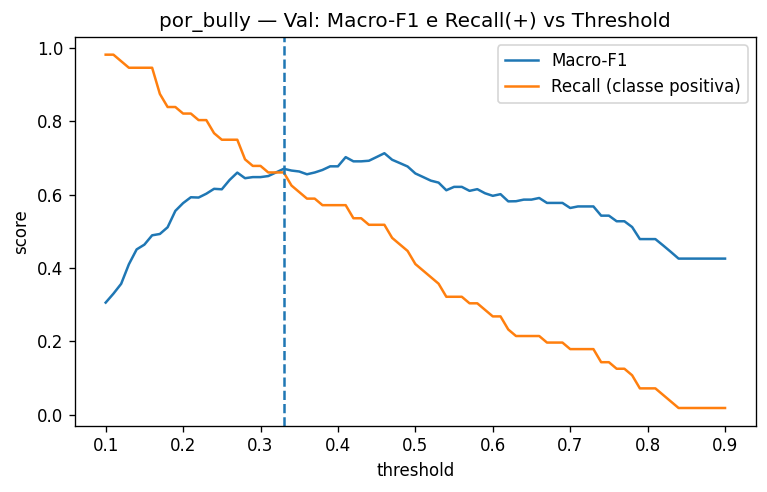


[por_bully] [TEST] accuracy: 0.7401 | macro_f1: 0.7101
[por_bully] [VAL ] accuracy: 0.6966 | macro_f1: 0.6706


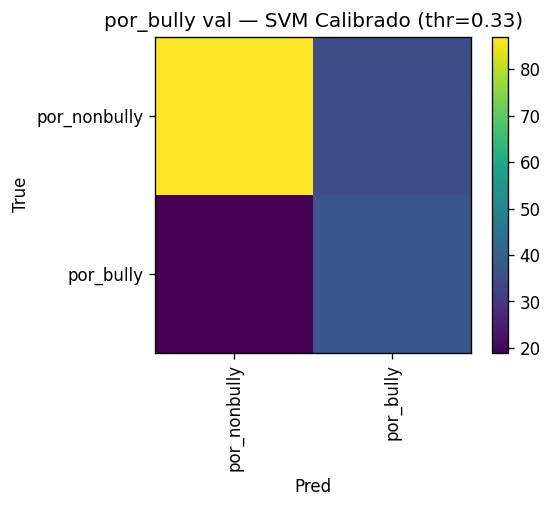

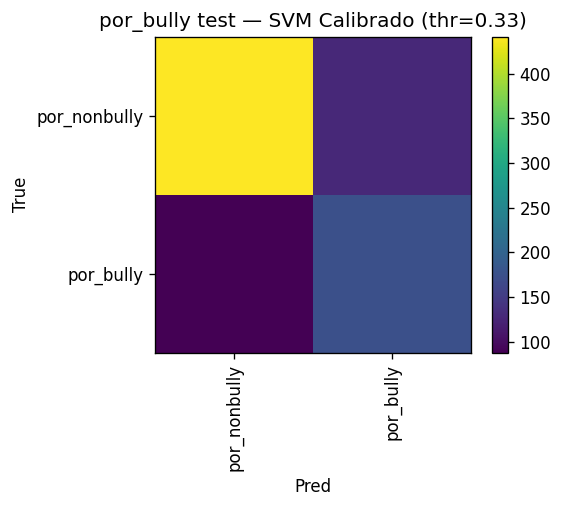

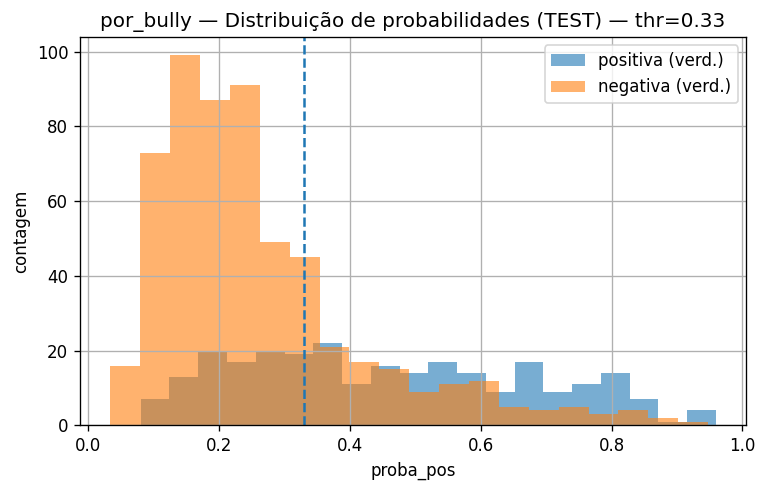


Top-3 FNs:
                                                                                                                                       text  proba_pos
     afinal, a privatização do ensino médio/superior brasileiro e o fim dos projetos sociais que ajudam milhões é o que vai levantar o país   0.080303
                                                                      ui nooooooofa que lindo fofa nosso galao e mara ne amiga rajkazblanks   0.080797
os bebés adoptados são c/ os telemóveis novos: qd os vamos buscar desesperamos se os deixamos cair. qd vemos 1 defeito,abrimos conta no olx   0.090017

Top-3 FPs:
                                                                                                                 text  proba_pos
                                                                                      eu só sigo sapatão e viado kkkk   0.947556
                                                                                                puta merda. que so

{'pipe': Pipeline(steps=[('feats',
                  FeatureUnion(transformer_list=[('word',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  strip_accents='unicode',
                                                                  sublinear_tf=True)),
                                                 ('char',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(3,
                                                                               7)))])),
                 ('clf',
                  CalibratedClassifierCV(cv=3,
                                         estimator=LinearSVC(C=3.0,
                                

In [7]:
CSV_PATH = "dataset.csv"
LANG3 = "por"         
POS_SUBSTR = "bully"

df_raw = pd.read_csv(CSV_PATH).dropna(subset=["text", "label"])
df_raw["label"] = df_raw["label"].astype(str)
df_raw["lang"] = df_raw["label"].str.split("_").str[0]

df = df_raw[df_raw["lang"] == LANG3][["text", "label"]].reset_index(drop=True)

labels = sorted(df["label"].unique())
pos_label = [l for l in labels if POS_SUBSTR in l][0]

run_experiment(df, pos_label=pos_label,
               name="por_bully",
               out_dir="por_bully_svmcal_out")

## HATEBRXPLAIN (label final / normalized_text):


[HateBRXplain] Splits:
train (5950, 2)
label
hatebr_nonhate    0.5
hatebr_hate       0.5
Name: proportion, dtype: float64 

val (185, 2)
label
hatebr_nonhate    0.503
hatebr_hate       0.497
Name: proportion, dtype: float64 

test (865, 2)
label
hatebr_hate       0.501
hatebr_nonhate    0.499
Name: proportion, dtype: float64 

[HateBRXplain] classes_: ['hatebr_hate', 'hatebr_nonhate'] | idx_pos: 0
[HateBRXplain] Threshold escolhido: 0.39 | Val Macro-F1: 0.9135
[HateBRXplain] Recall(+) min >= 0.6? True


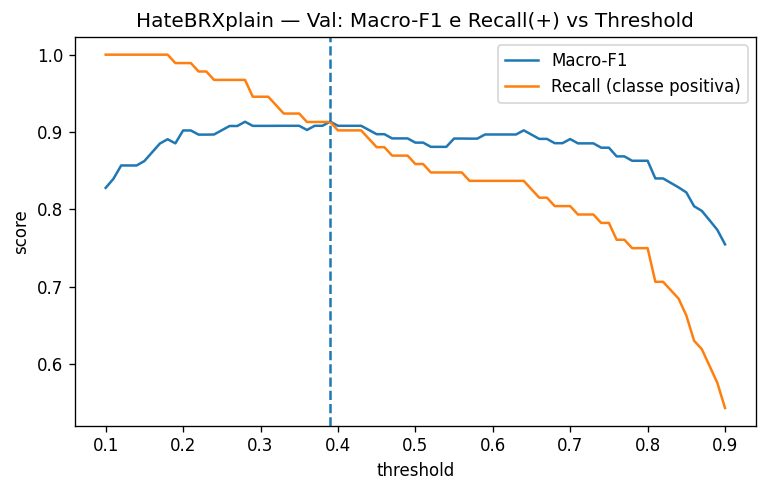


[HateBRXplain] [TEST] accuracy: 0.8601 | macro_f1: 0.8596
[HateBRXplain] [VAL ] accuracy: 0.9135 | macro_f1: 0.9135


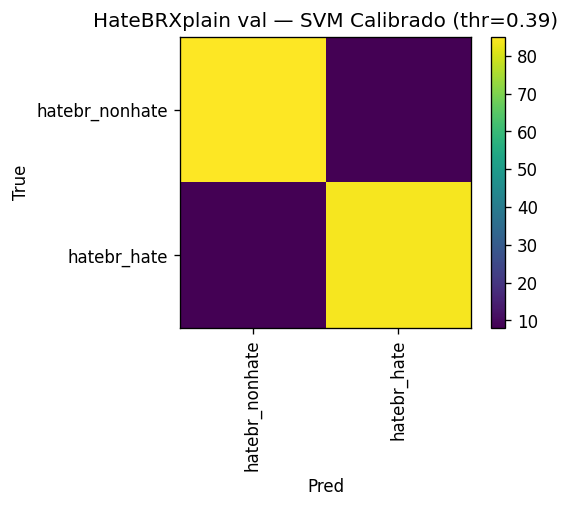

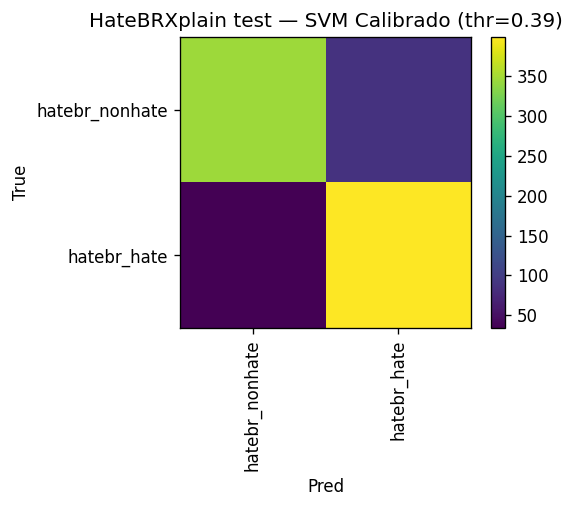

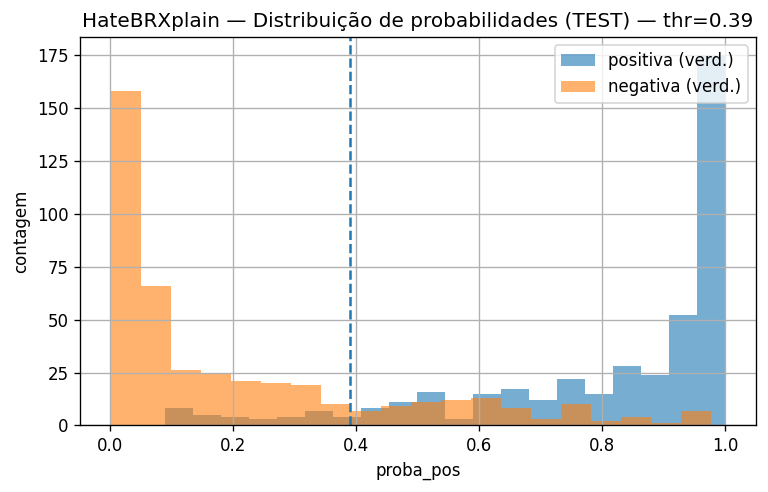


Top-3 FNs:
                                   text  proba_pos
                          demência será   0.089422
       ainda bem que nos livramos disso   0.099786
o ministro mais tombado da história lol   0.106959

Top-3 FPs:
                                                                                                                                                                                                                                                                                           text  proba_pos
ele não mentiu só tem coragem de falar o que bandido de colarinho branco tem medo querem calar o rapaz porque ele nos ajuda a pensar que há muitas alternativas pra combater bandidos e gente sem vergonha e corrupta e porque não pensar ou falar sobre é crime falar sobre algo que aconteceu   0.976206
                                                                                                                                                                              

{'pipe': Pipeline(steps=[('feats',
                  FeatureUnion(transformer_list=[('word',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  strip_accents='unicode',
                                                                  sublinear_tf=True)),
                                                 ('char',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(3,
                                                                               7)))])),
                 ('clf',
                  CalibratedClassifierCV(cv=3,
                                         estimator=LinearSVC(C=3.0,
                                

In [8]:
CSV_PATH = "hatebr_and_rationales.csv"

raw = pd.read_csv(CSV_PATH)

text_col = "normalized_text" if "normalized_text" in raw.columns else "comentario"
df = raw[[text_col, "label final"]].rename(columns={text_col: "text", "label final": "y"})
df = df.dropna(subset=["text", "y"]).reset_index(drop=True)

df["y"] = (df["y"].astype(float) > 0.5).astype(int)
df["label"] = df["y"].map({0: "hatebr_nonhate", 1: "hatebr_hate"})

run_experiment(df, pos_label="hatebr_hate",
               name="HateBRXplain",
               out_dir="hatebrxplain_svmcal_out")

## HATEBR Kaggle (hatespeech_comb):


[HateBR_Kaggle] Splits:
train (4819, 2)
label
hatebr_nonhate    0.685
hatebr_hate       0.315
Name: proportion, dtype: float64 

val (150, 2)
label
hatebr_nonhate    0.687
hatebr_hate       0.313
Name: proportion, dtype: float64 

test (701, 2)
label
hatebr_nonhate    0.685
hatebr_hate       0.315
Name: proportion, dtype: float64 

[HateBR_Kaggle] classes_: ['hatebr_hate', 'hatebr_nonhate'] | idx_pos: 0
[HateBR_Kaggle] Threshold escolhido: 0.30 | Val Macro-F1: 0.6791
[HateBR_Kaggle] Recall(+) min >= 0.6? True


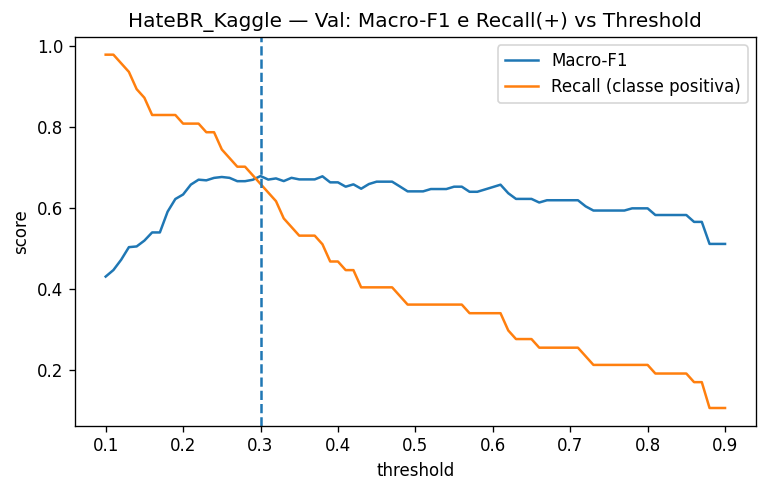


[HateBR_Kaggle] [TEST] accuracy: 0.6947 | macro_f1: 0.6713
[HateBR_Kaggle] [VAL ] accuracy: 0.7067 | macro_f1: 0.6791


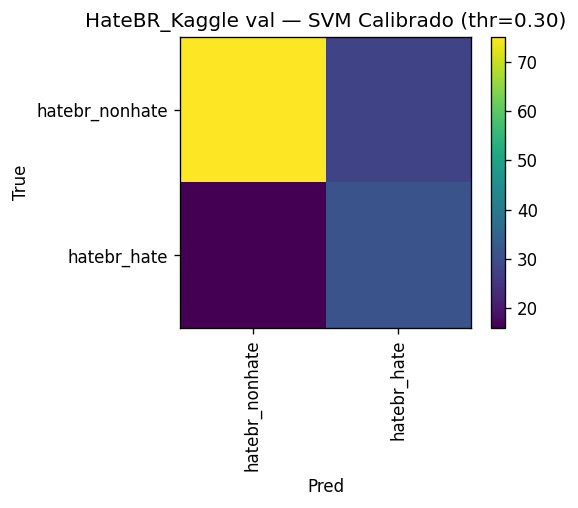

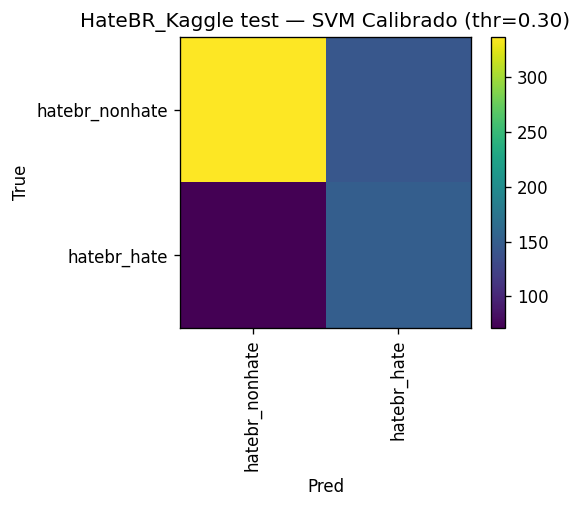

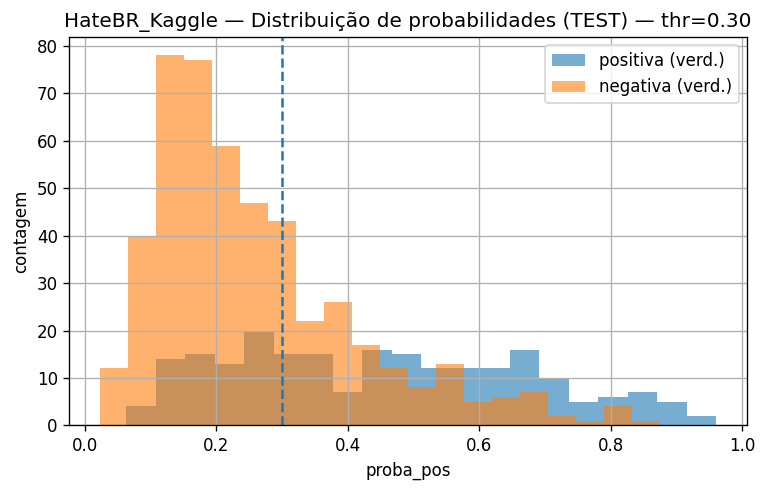


Top-3 FNs:
                                                                                                                                        text  proba_pos
                                           __user__ ora bem... já está a perder a linha. o verniz dos 'tolerantes' acaba sempre por estalar.   0.062957
a cp está a recrutar revisores e um dos requisitos é saber falar espanhol. talvez fosse mais importante contratar pessoas que saibam crioulo   0.076115
                                                                        o que é intervenção cívico militar?este vídeo me fez pensar. __url__   0.079523

Top-3 FPs:
                                                                                                                                        text  proba_pos
engraçado q se uma mulher não concorda com oq a maioria acha que é 'certo', as outras mulheres caem matando, chamando de burra, retardada...   0.874046
                                                                

{'pipe': Pipeline(steps=[('feats',
                  FeatureUnion(transformer_list=[('word',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  strip_accents='unicode',
                                                                  sublinear_tf=True)),
                                                 ('char',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(3,
                                                                               7)))])),
                 ('clf',
                  CalibratedClassifierCV(cv=3,
                                         estimator=LinearSVC(C=3.0,
                                

In [9]:
CSV_PATH = "brazilian_hate_speech_combined.csv"

raw = pd.read_csv(CSV_PATH)
df = pd.DataFrame({
    "text": raw["text"].astype(str),
    "label": np.where(raw["hatespeech_comb"] == 1,
                      "hatebr_hate", "hatebr_nonhate")
})

run_experiment(df, pos_label="hatebr_hate",
               name="HateBR_Kaggle",
               out_dir="hatebr_kaggle_svmcal_out")

## ToLD-Br (multi-label -> binário tóxico vs não-tóxico):


[ToLD-Br] Splits:
train (17850, 2)
label
told_nontoxic    0.559
told_toxic       0.441
Name: proportion, dtype: float64 

val (555, 2)
label
told_nontoxic    0.559
told_toxic       0.441
Name: proportion, dtype: float64 

test (2595, 2)
label
told_nontoxic    0.56
told_toxic       0.44
Name: proportion, dtype: float64 

[ToLD-Br] classes_: ['told_nontoxic', 'told_toxic'] | idx_pos: 1
[ToLD-Br] Threshold escolhido: 0.50 | Val Macro-F1: 0.7768
[ToLD-Br] Recall(+) min >= 0.6? True


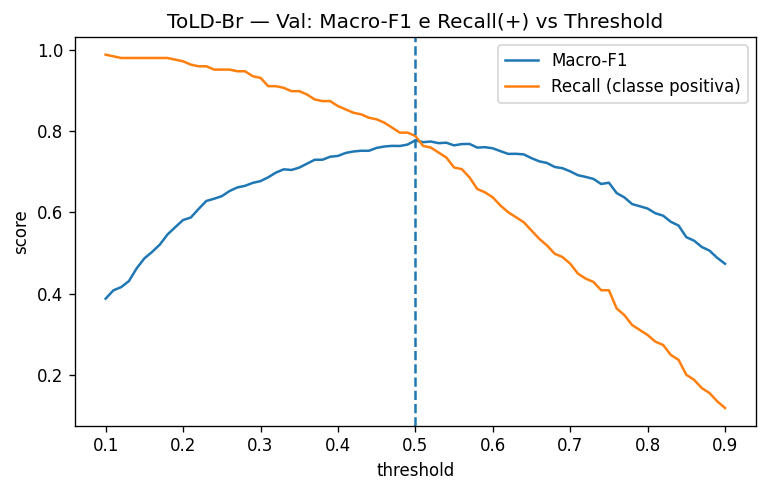


[ToLD-Br] [TEST] accuracy: 0.7372 | macro_f1: 0.7342
[ToLD-Br] [VAL ] accuracy: 0.7784 | macro_f1: 0.7768


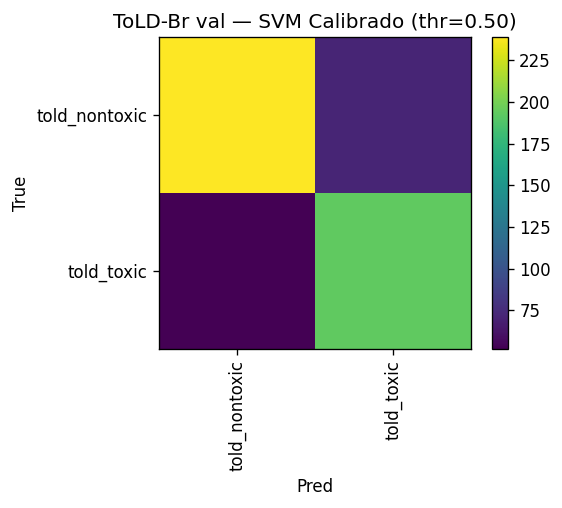

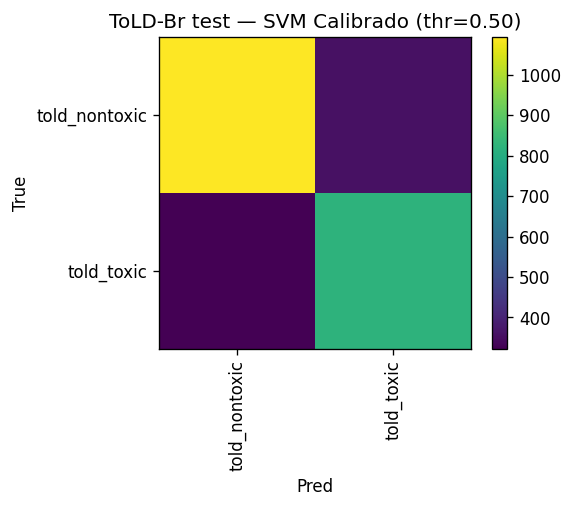

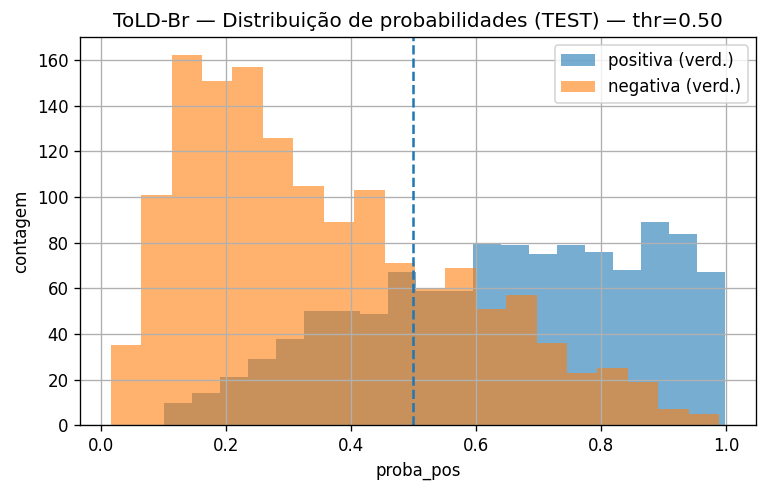


Top-3 FNs:
                                                                                                     text  proba_pos
__user__ o ruim 茅 que n茫o tem nenhum outro para representar, tipo para o s茫o paulo que s贸 tem veado mesmo   0.100543
                                                                   __user__ manda os dois pro mesmo lugar   0.102913
                                                                        sou inútil nem isso consigo fazer   0.115538

Top-3 FPs:
                                                                                        text  proba_pos
                                                                        pqp, q video caralho   0.988709
                                                     cara, que merda. ser assediada é um cu.   0.984598
irmão, sério mesmo, eu nasci pra ser feita de otária pqp enfia ela no seu cu também caralho.   0.966083

[ToLD-Br] Artefatos em: C:\dev\NLP-Final-Project\toldbr_svmcal_out


{'pipe': Pipeline(steps=[('feats',
                  FeatureUnion(transformer_list=[('word',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  strip_accents='unicode',
                                                                  sublinear_tf=True)),
                                                 ('char',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(3,
                                                                               7)))])),
                 ('clf',
                  CalibratedClassifierCV(cv=3,
                                         estimator=LinearSVC(C=3.0,
                                

In [10]:
CSV_PATH = "toldbr_raw.csv"

df_raw = pd.read_csv(CSV_PATH)

cols_lab = ["homophobia","obscene","insult","racism","misogyny","xenophobia"]
tox_mask = (df_raw[cols_lab] > 0).any(axis=1)

df = pd.DataFrame({
    "text": df_raw["text"].astype(str),
    "label": np.where(tox_mask, "told_toxic", "told_nontoxic")
})

run_experiment(df, pos_label="told_toxic",
               name="ToLD-Br",
               out_dir="toldbr_svmcal_out")